Mounted at /content/drive
Epoch 1/100, Generator Loss: 0.9985337257385254, Discriminator Loss: 0.8151430487632751, Discriminator Accuracy: 0.8333333134651184
Epoch 2/100, Generator Loss: 3.1860077381134033, Discriminator Loss: 0.07367832213640213, Discriminator Accuracy: 1.0
Epoch 3/100, Generator Loss: 5.550675868988037, Discriminator Loss: 0.009640218690037727, Discriminator Accuracy: 1.0
Epoch 4/100, Generator Loss: 6.741081237792969, Discriminator Loss: 0.0032923694234341383, Discriminator Accuracy: 1.0
Epoch 5/100, Generator Loss: 6.7920823097229, Discriminator Loss: 0.0019350157817825675, Discriminator Accuracy: 1.0
Epoch 6/100, Generator Loss: 6.188823699951172, Discriminator Loss: 0.0026778068859130144, Discriminator Accuracy: 1.0
Epoch 7/100, Generator Loss: 5.383655071258545, Discriminator Loss: 0.00524670397862792, Discriminator Accuracy: 1.0
Epoch 8/100, Generator Loss: 5.13236665725708, Discriminator Loss: 0.006493976805359125, Discriminator Accuracy: 1.0
Epoch 9/100, Gene

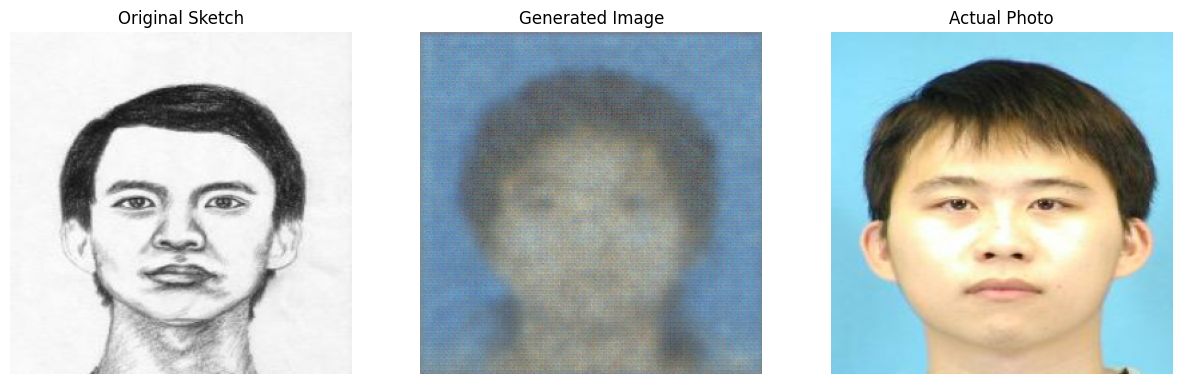

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.optimizers import Adam
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define paths to training and testing data
training_sketch_path = '/content/drive/MyDrive/CUHK/sketch/Training sketch/'
training_photo_path = '/content/drive/MyDrive/CUHK/photo/Training photo/'
testing_sketch_path = '/content/drive/MyDrive/CUHK/sketch/Testing sketch/'
testing_photo_path = "/content/drive/MyDrive/CUHK/photo/Testing photo/"

# Define constants
IMAGE_SIZE = (256, 256)
BATCH_SIZE = 32
EPOCHS = 100
LATENT_DIM = 100

# Function to load and preprocess image
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.cast(img, tf.float32)
    img = (img - 127.5) / 127.5  # Normalize the images to [-1, 1]
    return img

# Load and preprocess training data
train_sketch_dataset = tf.data.Dataset.list_files(training_sketch_path + '*.jpg')
train_photo_dataset = tf.data.Dataset.list_files(training_photo_path + '*.jpg')

train_sketch_dataset = train_sketch_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE)
train_photo_dataset = train_photo_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE)

# Load and preprocess testing data
test_sketch_dataset = tf.data.Dataset.list_files(testing_sketch_path + '*.jpg')
test_photo_dataset = tf.data.Dataset.list_files(testing_photo_path + '*.jpg')

test_sketch_dataset = test_sketch_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE)
test_photo_dataset = test_photo_dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE)

# Define Generator
def build_generator():
    inputs = Input(shape=(LATENT_DIM,))
    x = layers.Dense(64*64*64, use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.Reshape((64, 64, 64))(x)

    x = layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU()(x)

    x = layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')(x)

    return Model(inputs, x)

# Define Discriminator
def build_discriminator():
    inputs = Input(shape=(256, 256, 3))
    x = layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')(inputs)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')(x)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Flatten()(x)
    x = layers.Dense(1)(x)

    return Model(inputs, x)

# Initialize the models
generator = build_generator()
discriminator = build_discriminator()

# Define loss functions
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Define generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Define discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# Define optimizers
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

# Define checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Define training step
@tf.function
def train_step(sketch_images, photo_images):
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(photo_images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    # Compute discriminator accuracy
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant(0.5)), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant(0.5)), tf.float32))
    disc_accuracy = 0.5 * (real_accuracy + fake_accuracy)

    return gen_loss, disc_loss, disc_accuracy

# Training loop
def train(dataset, epochs):
    for epoch in range(epochs):
        total_gen_loss = 0
        total_disc_loss = 0
        total_accuracy = 0
        num_batches = 0

        for sketch_batch, photo_batch in zip(train_sketch_dataset, train_photo_dataset):
            gen_loss, disc_loss, disc_accuracy = train_step(sketch_batch, photo_batch)
            total_gen_loss += gen_loss
            total_disc_loss += disc_loss
            total_accuracy += disc_accuracy
            num_batches += 1

        average_gen_loss = total_gen_loss / num_batches
        average_disc_loss = total_disc_loss / num_batches
        average_accuracy = total_accuracy / num_batches

        print(f"Epoch {epoch + 1}/{epochs}, Generator Loss: {average_gen_loss}, Discriminator Loss: {average_disc_loss}, Discriminator Accuracy: {average_accuracy}")

    return average_gen_loss, average_disc_loss, average_accuracy

# Define a function to generate and display a new image from the same sketch
def generate_and_display_new_image(generator, original_sketch, actual_photo):
    noise = tf.random.normal([1, LATENT_DIM])  # Generate new random noise
    generated_image = generator(noise, training=False)

    plt.figure(figsize=(15, 5))

    # Display original sketch
    plt.subplot(1, 3, 1)
    plt.imshow(original_sketch[0] * 0.5 + 0.5)
    plt.title('Original Sketch')
    plt.axis('off')

    # Display generated image
    plt.subplot(1, 3, 2)
    plt.imshow(generated_image[0] * 0.5 + 0.5)
    plt.title('Generated Image')
    plt.axis('off')

    # Display actual photo
    plt.subplot(1, 3, 3)
    plt.imshow(actual_photo[0] * 0.5 + 0.5)
    plt.title('Actual Photo')
    plt.axis('off')

    plt.show()

# Train the model
gen_loss, disc_loss, disc_accuracy = train(train_sketch_dataset, EPOCHS)

# Select a random sketch and its corresponding photo from the test set
random_index = np.random.randint(0, len(test_sketch_dataset))
print(random_index)
random_sketch = next(iter(test_sketch_dataset.skip(random_index).take(1)))
actual_photo = next(iter(test_photo_dataset.skip(random_index).take(1)))

# Generate and display a new image from the same sketch
generate_and_display_new_image(generator, random_sketch, actual_photo)
generator.save('/content/drive/MyDrive/face_sketch_model.h5')